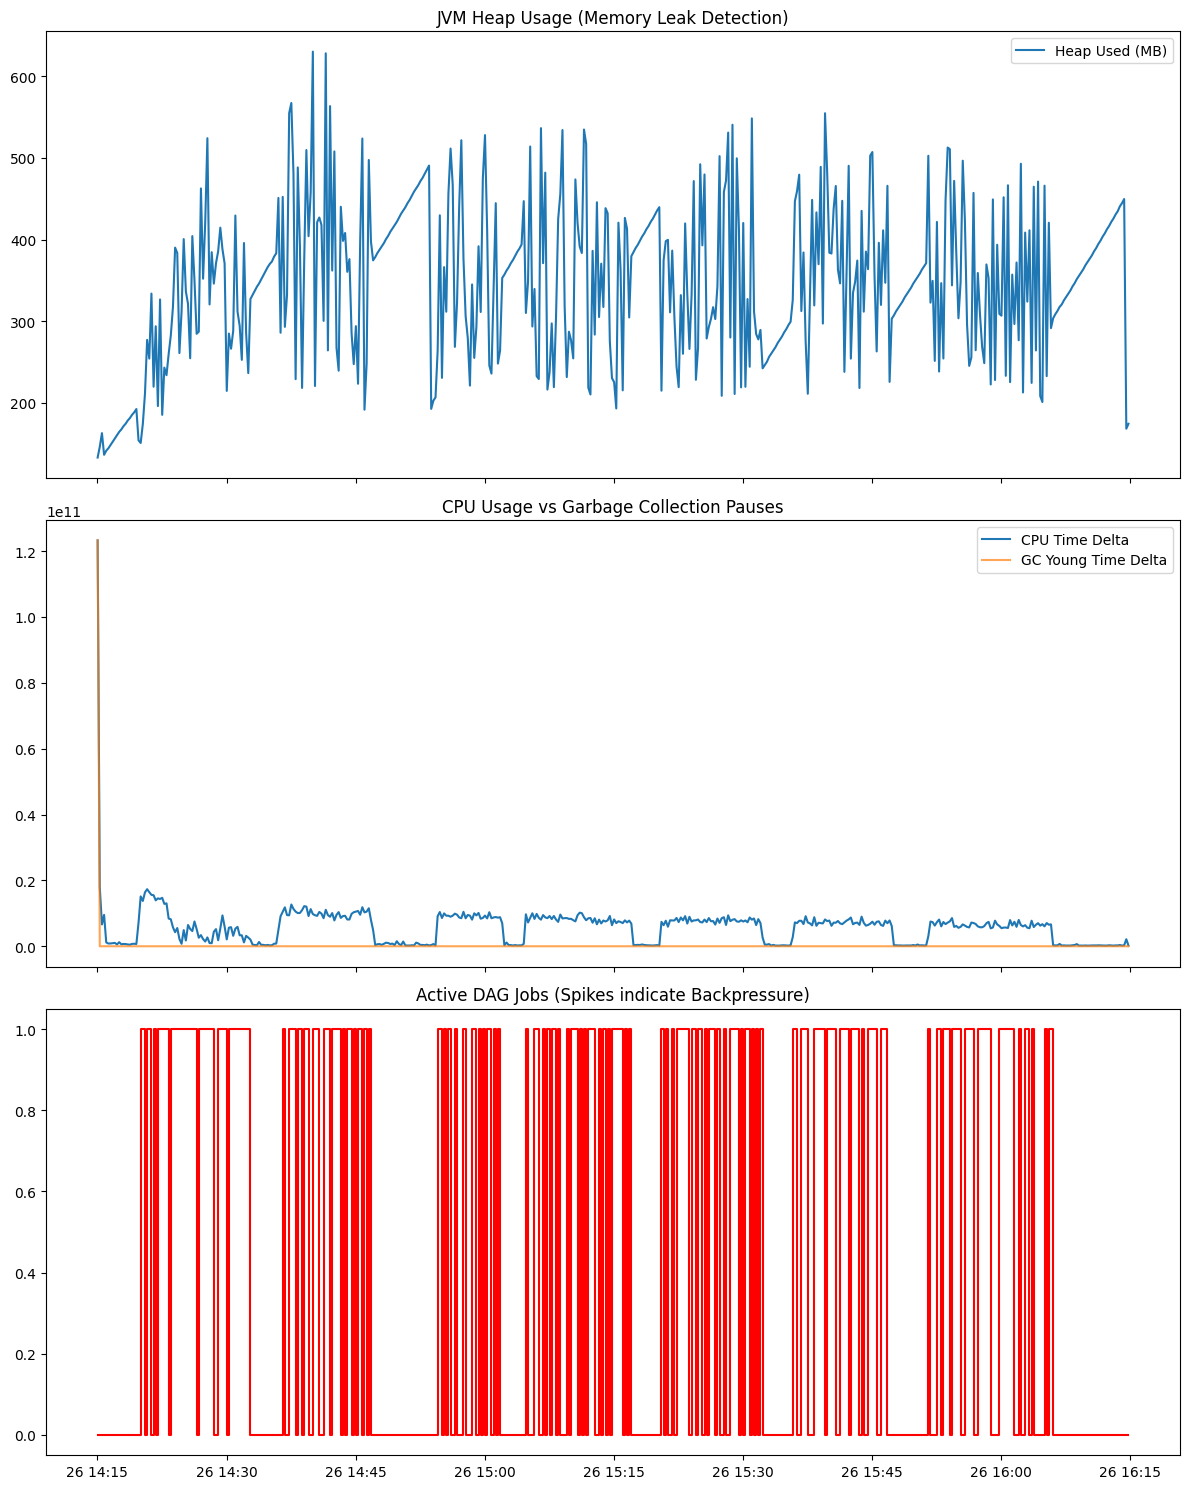

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

def analyze_spark_metrics(directory="."):
    # 1. Load the most critical files
    # Mapping friendly names to the long parquet filenames
    metric_files = {
        "Heap_Used": "*jvm_heap_used_Value.parquet",
        "CPU_Time": "*JVMCPU_jvmCpuTime_Value.parquet",
        "GC_Young": "*jvm_G1_Young_Generation_time_Value.parquet",
        "Active_Jobs": "*DAGScheduler_job_activeJobs_Value.parquet"
    }
    
    dataframes = {}
    
    for label, pattern in metric_files.items():
        files = glob.glob(os.path.join(directory, pattern))
        if files:
            # Assuming the parquet has 'timestamp' and 'value' columns
            df = pd.read_parquet(files[0])
            # Prometheus exports usually have 'timestamp' and 'value'
            df = df.sort_index()

            df.index = df.index.to_series() - pd.Timedelta(hours=3)

            df = df[df.index > pd.Timestamp('2025-12-26 14:15:00')]
            df = df[df.index < pd.Timestamp('2025-12-26 16:15:00')]
            dataframes[label] = df

    if not dataframes:
        print("No matching parquet files found.")
        return

    # 2. Visualization
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

    # Plot 1: Memory Health (Sawtooth check)
    if "Heap_Used" in dataframes:
        axes[0].plot(dataframes["Heap_Used"].index, 
                    dataframes["Heap_Used"]["value"] / (1024**2), label="Heap Used (MB)")
        axes[0].set_title("JVM Heap Usage (Memory Leak Detection)")
        axes[0].legend()

    # Plot 2: CPU vs GC (Bottleneck check)
    if "CPU_Time" in dataframes and "GC_Young" in dataframes:
        # Calculate delta/diff for CPU because it's usually a cumulative counter
        cpu_diff = dataframes["CPU_Time"]["value"].diff()
        gc_diff = dataframes["GC_Young"]["value"].diff()

        cpu_diff = cpu_diff.where(cpu_diff >= 0, dataframes["CPU_Time"]["value"])
        gc_diff = gc_diff.where(gc_diff >= 0, dataframes["CPU_Time"]["value"])

        axes[1].plot(dataframes["CPU_Time"].index, cpu_diff, label="CPU Time Delta")
        axes[1].plot(dataframes["GC_Young"].index, gc_diff, label="GC Young Time Delta", alpha=0.7)
        axes[1].set_title("CPU Usage vs Garbage Collection Pauses")
        axes[1].legend()

    # Plot 3: Scheduling (Backpressure check)
    if "Active_Jobs" in dataframes:
        axes[2].step(dataframes["Active_Jobs"].index, 
                    dataframes["Active_Jobs"]["value"], where='post', color='red')
        axes[2].set_title("Active DAG Jobs (Spikes indicate Backpressure)")

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_spark_metrics("../../data/raw/experiment08/experiment08_edge")

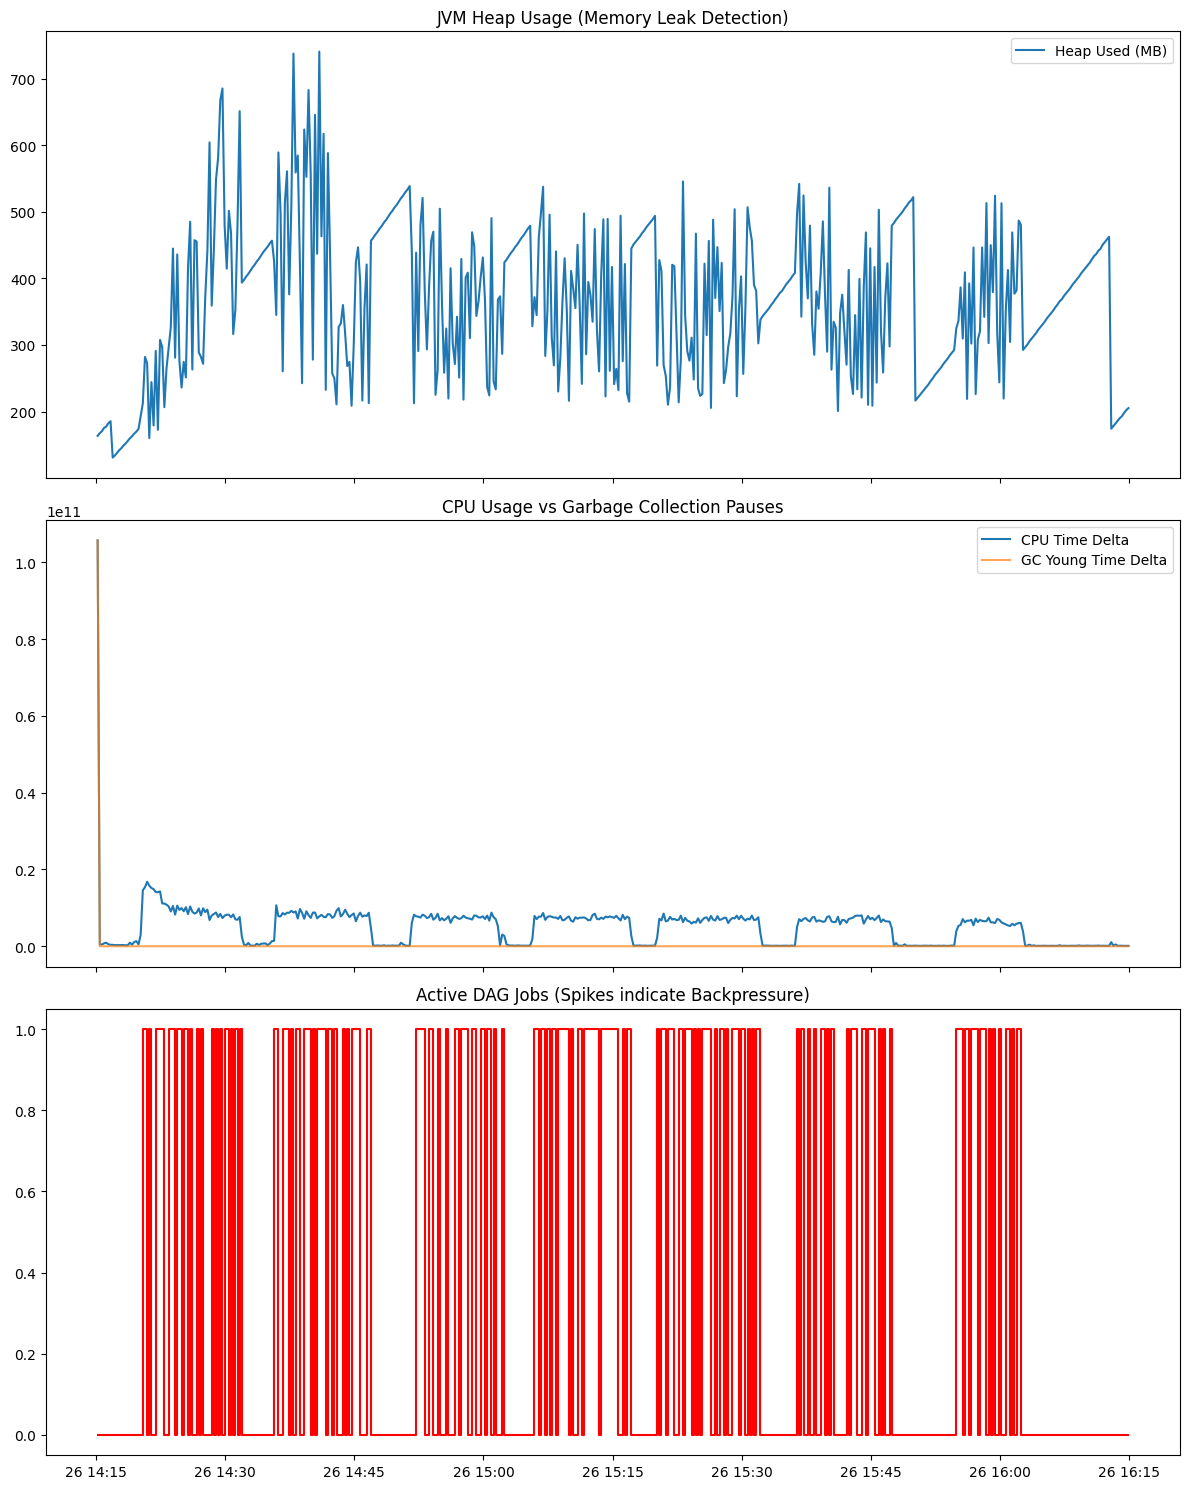

In [5]:
analyze_spark_metrics("../../data/raw/experiment08/experiment08_cloud")